In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, LSTM, Bidirectional
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2023-03-07 22:22:07.579700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 22:22:07.712856: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 22:22:07.718295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 22:22:07.718311: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
data = pd.read_csv('data/processed/elderly_body_combined.csv')
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr
0,Falling,-1.896115,0.065920,0.233467,27.588733,-26.734214,4.394665
1,Falling,-1.868648,0.069582,0.218818,24.292734,-31.861324,6.469924
2,Falling,-1.858577,0.041200,0.200507,22.583697,-38.941618,8.789331
3,Falling,-1.847591,0.032044,0.250862,19.531846,-43.458357,11.108737
4,Falling,-1.869564,0.026551,0.271920,16.602069,-48.097171,10.132145


In [3]:
data.shape

(234894, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234894 entries, 0 to 234893
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   234894 non-null  object 
 1   x_acc   234894 non-null  float64
 2   y_acc   234894 non-null  float64
 3   z_acc   234894 non-null  float64
 4   x_gyr   234894 non-null  float64
 5   y_gyr   234894 non-null  float64
 6   z_gyr   234894 non-null  float64
dtypes: float64(6), object(1)
memory usage: 12.5+ MB


In [5]:
# check for null data
data.isnull().sum()

label    0
x_acc    0
y_acc    0
z_acc    0
x_gyr    0
y_gyr    0
z_gyr    0
dtype: int64

In [6]:
# count the datapoints of different activity
data['label'].value_counts()

Walking    83754
Running    69168
Stairs     58542
Sitting    12210
Falling    11220
Name: label, dtype: int64

### Balance this data 

In [7]:
# convert attributes to floats
data['x_acc'] = data['x_acc'].astype('float')
data['y_acc'] = data['y_acc'].astype('float')
data['z_acc'] = data['z_acc'].astype('float')
data['x_gyr'] = data['x_gyr'].astype('float')
data['y_gyr'] = data['y_gyr'].astype('float')
data['z_gyr'] = data['z_gyr'].astype('float')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234894 entries, 0 to 234893
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   234894 non-null  object 
 1   x_acc   234894 non-null  float64
 2   y_acc   234894 non-null  float64
 3   z_acc   234894 non-null  float64
 4   x_gyr   234894 non-null  float64
 5   y_gyr   234894 non-null  float64
 6   z_gyr   234894 non-null  float64
dtypes: float64(6), object(1)
memory usage: 12.5+ MB


In [9]:
# frame size, Frames per second
Fs = 33

In [10]:
activities = data['label'].value_counts().index

In [11]:
activities

Index(['Walking', 'Running', 'Stairs', 'Sitting', 'Falling'], dtype='object')

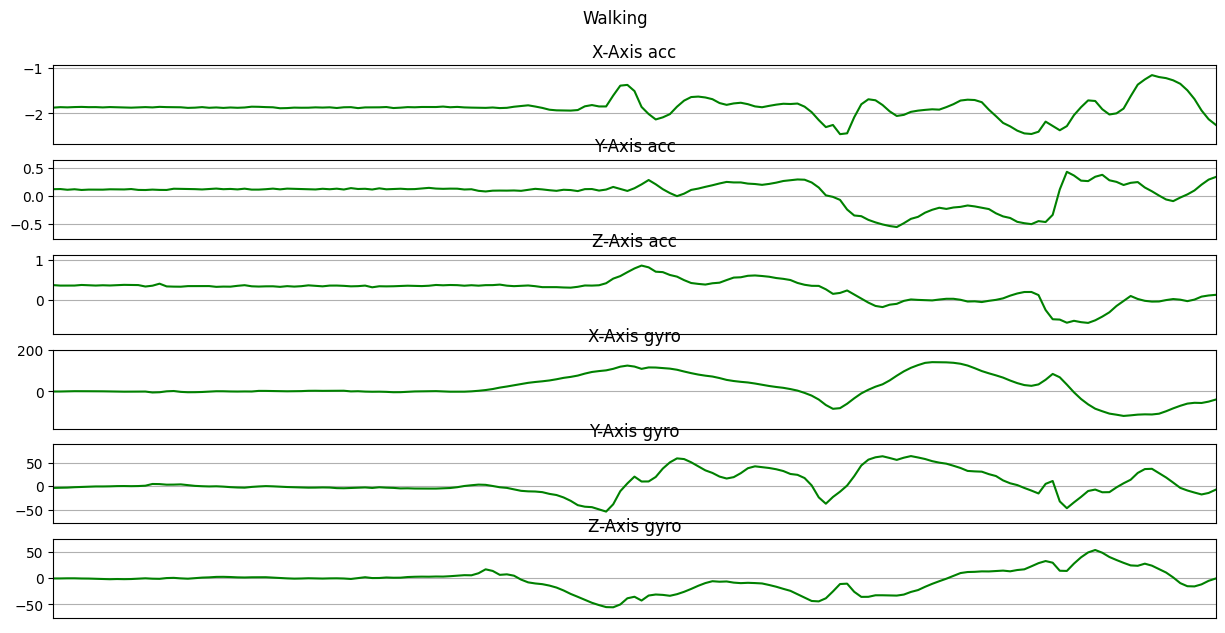

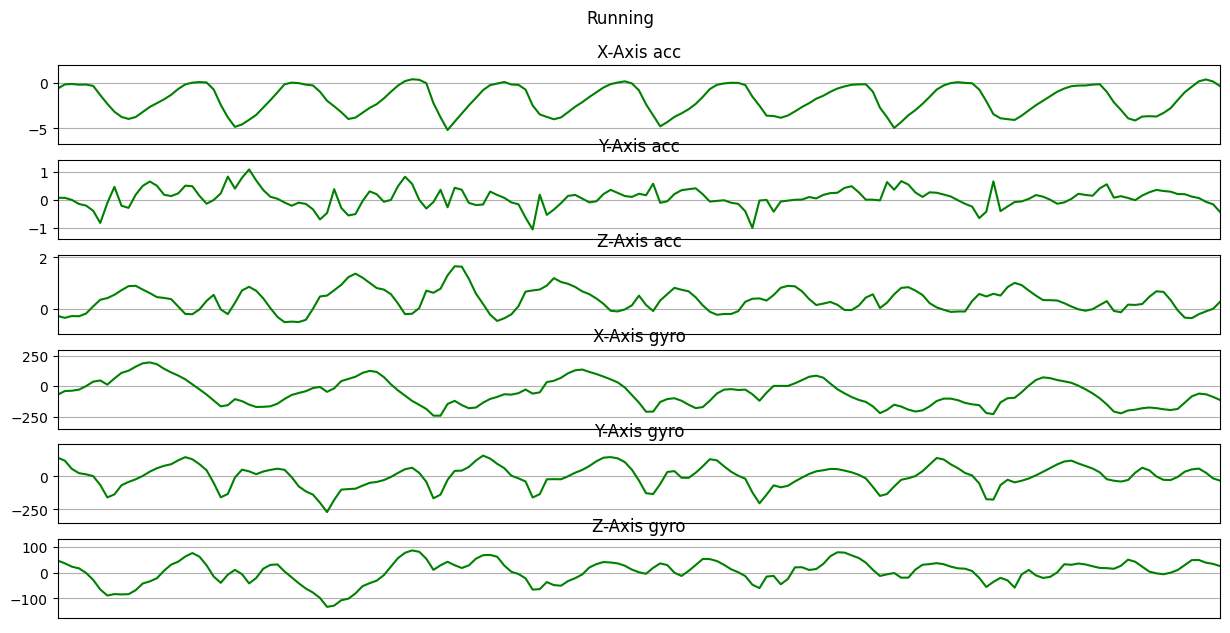

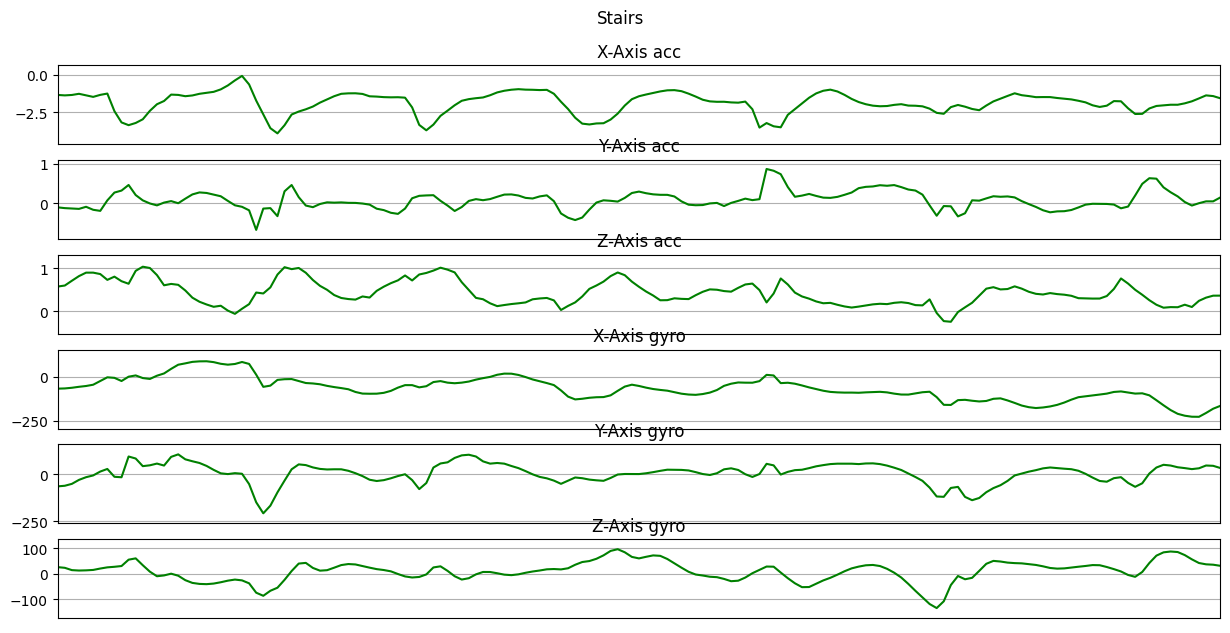

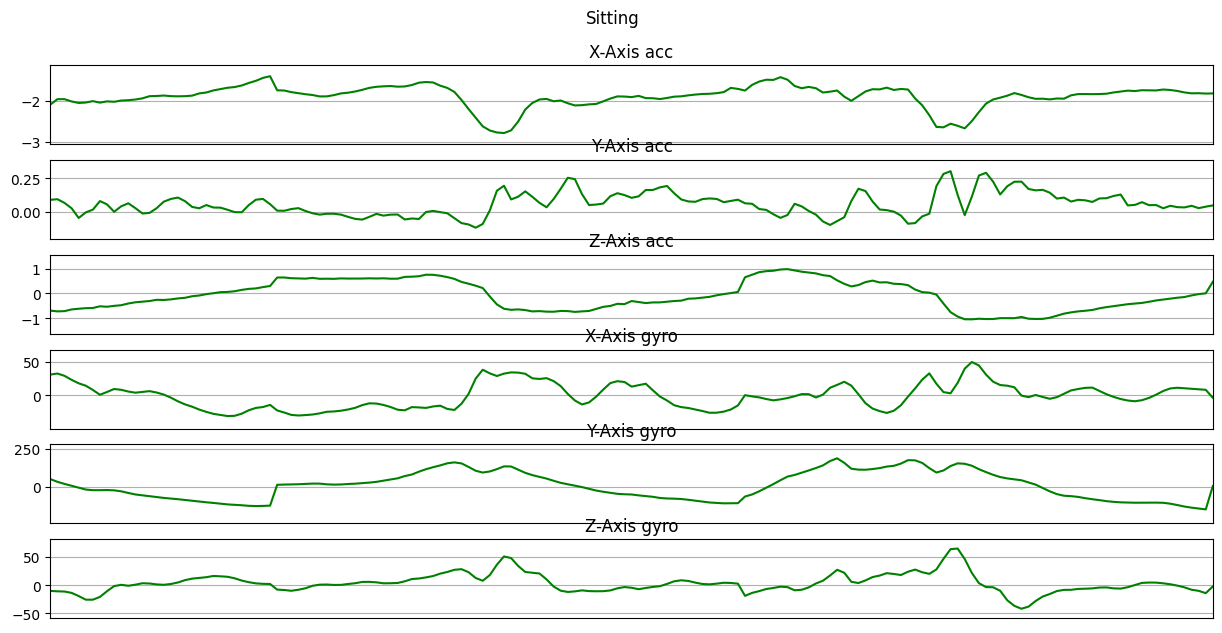

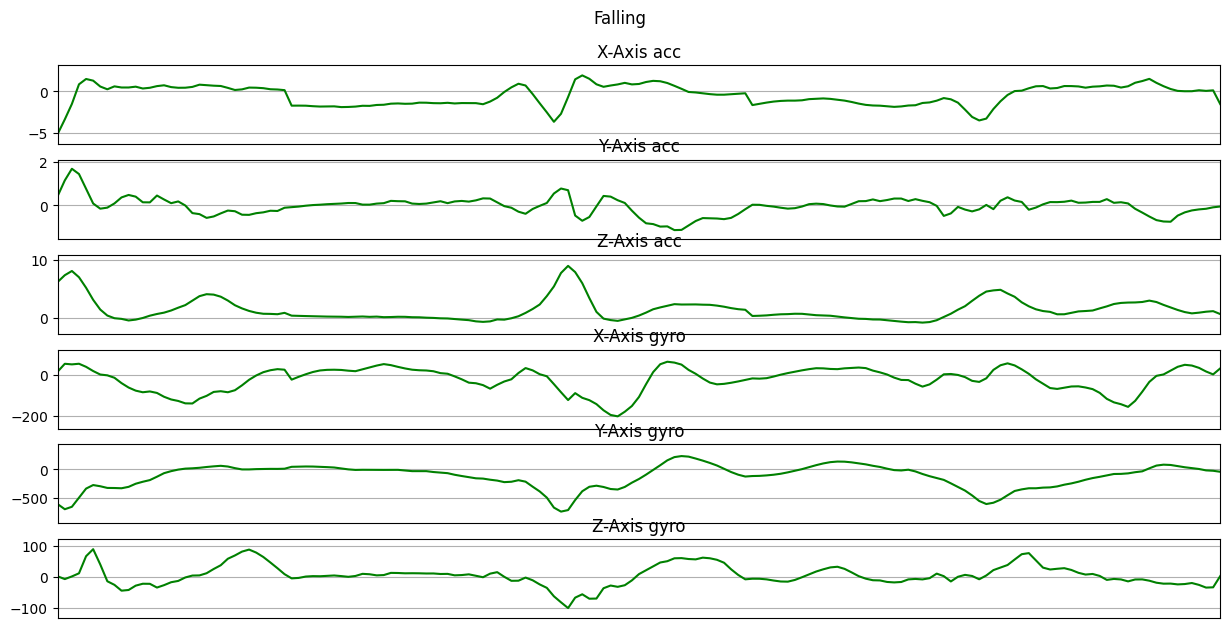

In [12]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, figsize=(15, 7), sharex=True)
    x_ticks = np.arange(len(data))
    plot_axis(ax0, x_ticks, data['x_acc'], 'X-Axis acc')
    plot_axis(ax1, x_ticks, data['y_acc'], 'Y-Axis acc')
    plot_axis(ax2, x_ticks, data['z_acc'], 'Z-Axis acc')
    plot_axis(ax3, x_ticks, data['x_gyr'], 'X-Axis gyro')
    plot_axis(ax4, x_ticks, data['y_gyr'], 'Y-Axis gyro')
    plot_axis(ax5, x_ticks, data['z_gyr'], 'Z-Axis gyro')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['label'] == activity)][Fs*5:Fs*10]
    plot_activity(activity, data_for_plot)

In [13]:
counts = data['label'].value_counts()
counts

Walking    83754
Running    69168
Stairs     58542
Sitting    12210
Falling    11220
Name: label, dtype: int64

In [14]:
# calculate weights to balance weights on imbalance classes
# references: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
# references: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
n_classes = 5
n_total = data.shape[0]

weight_0 = n_total / (n_classes * counts[0]) # 
weight_1 = n_total / (n_classes * counts[1]) #
weight_2 = n_total / (n_classes * counts[2])
weight_3 = n_total / (n_classes * counts[3])
weight_4 = n_total / (n_classes * counts[4])
class_weight = {0: weight_0, 1: weight_1, 2:weight_2, 3: weight_3, 4: weight_4}

In [15]:
class_weight

{0: 0.5609141055949567,
 1: 0.6791984732824428,
 2: 0.8024802705749718,
 3: 3.8475675675675673,
 4: 4.187058823529412}

In [16]:
data.shape

(234894, 7)

In [17]:
data['label'].value_counts()

Walking    83754
Running    69168
Stairs     58542
Sitting    12210
Falling    11220
Name: label, dtype: int64

In [18]:
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr
0,Falling,-1.896115,0.065920,0.233467,27.588733,-26.734214,4.394665
1,Falling,-1.868648,0.069582,0.218818,24.292734,-31.861324,6.469924
2,Falling,-1.858577,0.041200,0.200507,22.583697,-38.941618,8.789331
3,Falling,-1.847591,0.032044,0.250862,19.531846,-43.458357,11.108737
4,Falling,-1.869564,0.026551,0.271920,16.602069,-48.097171,10.132145


In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
label = LabelEncoder()
data['label_id'] = label.fit_transform(data['label'])
data.tail()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
234889,Walking,-2.012391,0.450453,0.207831,14.404736,-10.620441,20.020142,4
234890,Walking,-2.122257,0.277413,0.282907,-8.667257,-3.784295,26.001770,4
234891,Walking,-2.005982,0.156560,0.313120,-17.334513,-1.709037,27.466659,4
234892,Walking,-1.810968,0.079653,0.304880,-27.954955,12.573626,20.752586,4
234893,Walking,-1.754204,0.097964,0.302133,-27.222510,14.526811,3.784295,4


In [21]:
label.classes_

array(['Falling', 'Running', 'Sitting', 'Stairs', 'Walking'], dtype=object)

### Standardized data 

In [22]:
X = data[['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr']]
y = data['label_id']

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr'])
scaled_X['label_id'] = y.values

scaled_X

,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
0,-0.147940,0.145744,-0.288482,0.418518,-0.392026,0.019395,0
1,-0.110983,0.155502,-0.315099,0.381535,-0.468131,0.061890,0
2,-0.097432,0.079876,-0.348370,0.362359,-0.573228,0.109385,0
3,-0.082649,0.055480,-0.256874,0.328117,-0.640273,0.156880,0
4,-0.112214,0.040843,-0.218612,0.295243,-0.709129,0.136882,0
...,...,...,...,...,...,...,...
234889,-0.304393,1.170355,-0.335062,0.270588,-0.152840,0.339361,4
234890,-0.452222,0.709280,-0.198649,0.011712,-0.051367,0.461849,4
234891,-0.295769,0.387259,-0.143751,-0.085538,-0.020563,0.491846,4
234892,-0.033372,0.182337,-0.158723,-0.204703,0.191444,0.354360,4


### Frame Preparation 

In [24]:
import scipy.stats as stats

In [26]:
Fs = 33
frame_size = Fs*2
hop_size = 66

In [27]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 6
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x_acc = df['x_acc'].values[i: i + frame_size]
        y_acc = df['y_acc'].values[i: i + frame_size]
        z_acc = df['z_acc'].values[i: i + frame_size]
        x_gyr = df['x_gyr'].values[i: i + frame_size]
        y_gyr = df['y_gyr'].values[i: i + frame_size]
        z_gyr = df['z_gyr'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label_id'][i: i + frame_size])[0][0]
        frames.append([x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [28]:
X, y = get_frames(scaled_X, frame_size, hop_size)

/tmp/ipykernel_140866/3703171814.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label_id'][i: i + frame_size])[0][0]


In [29]:
X.shape, y.shape

((3558, 66, 6), (3558,))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7, stratify = y)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 7, stratify = y_train)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2846, 66, 6)
(2846,)
(712, 66, 6)
(712,)


In [34]:
X_train.shape, X_test.shape

((2846, 66, 6), (712, 66, 6))

In [35]:
X_train[0].shape, X_test[0].shape

((66, 6), (66, 6))

In [36]:
X_train = X_train.reshape(X_train.shape[0], 66, 6, 1)
X_val = X_val.reshape(X_val.shape[0], 66, 6, 1)
X_test = X_test.reshape(X_test.shape[0], 66, 6, 1)

In [37]:
X_train.shape, X_val.shape, X_test.shape, 

((2846, 66, 6, 1), (570, 66, 6, 1), (712, 66, 6, 1))

### 2D CNN Model 

In [38]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

2023-03-07 22:23:26.138903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 22:23:26.139035: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-07 22:23:26.139124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-07 22:23:26.142349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-03-07 22:23:26.142450: W tensorflow/stream_executor/platform/default/dso_loader

### LSTM

In [40]:
X_train = X_train.reshape(X_train.shape[0], 66, 6)
X_test = X_test.reshape(X_test.shape[0], 66, 6)

In [41]:
model = Sequential()
model.add(LSTM(units=128, input_shape= X_train[0].shape, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128, input_shape= X_train[0].shape, return_sequences=True))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [42]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [43]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_train, y_train, epochs = 100, validation_split=0.1, verbose=1, callbacks = [es])

# count the number of epochs after early stopping
number_of_epochs = len(history.history['loss'])

Epoch 1/100
81/81 [==============================] - 18s 188ms/step - loss: 0.7752 - accuracy: 0.7220 - val_loss: 0.5174 - val_accuracy: 0.8316
Epoch 2/100
81/81 [==============================] - 14s 177ms/step - loss: 0.4691 - accuracy: 0.8200 - val_loss: 0.4390 - val_accuracy: 0.8246
Epoch 3/100
81/81 [==============================] - 14s 177ms/step - loss: 0.4145 - accuracy: 0.8555 - val_loss: 0.3984 - val_accuracy: 0.8842
Epoch 4/100
81/81 [==============================] - 14s 177ms/step - loss: 0.3340 - accuracy: 0.8774 - val_loss: 0.2780 - val_accuracy: 0.8947
Epoch 5/100
81/81 [==============================] - 14s 178ms/step - loss: 0.3145 - accuracy: 0.8782 - val_loss: 0.3002 - val_accuracy: 0.9053
Epoch 6/100
81/81 [==============================] - 14s 178ms/step - loss: 0.2785 - accuracy: 0.8930 - val_loss: 0.2921 - val_accuracy: 0.9123
Epoch 7/100
81/81 [==============================] - 14s 177ms/step - loss: 0.2576 - accuracy: 0.9008 - val_loss: 0.2763 - val_accuracy:

In [49]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

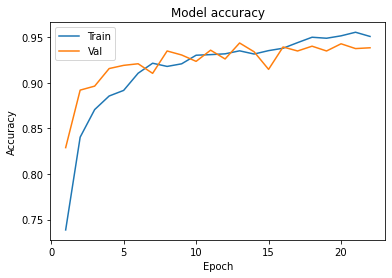

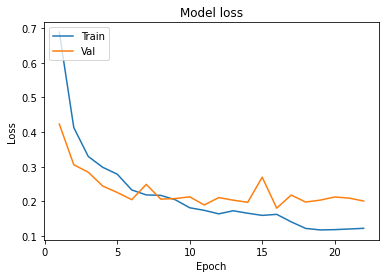

In [50]:
plot_learningCurve(history, number_of_epochs)

### Confusion Matrix 

In [46]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 66, 128)           69120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 66, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 66, 128)           131584    
_________________________________________________________________
flatten_3 (Flatten)          (None, 8448)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                540736    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                

In [53]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

0.9438202247191011

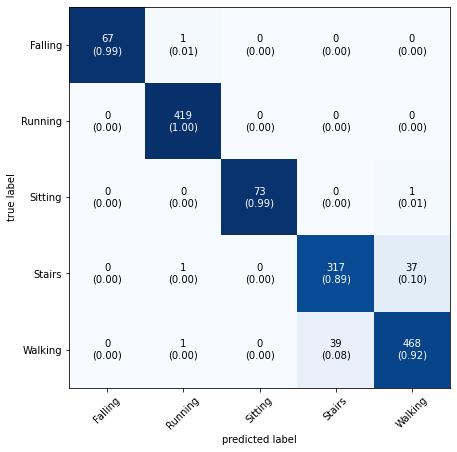

In [54]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)

In [44]:
model.save('models/new/lstm_6_elderly_body.h5')

23/23 [==============================] - 1s 27ms/step


0.48314606741573035

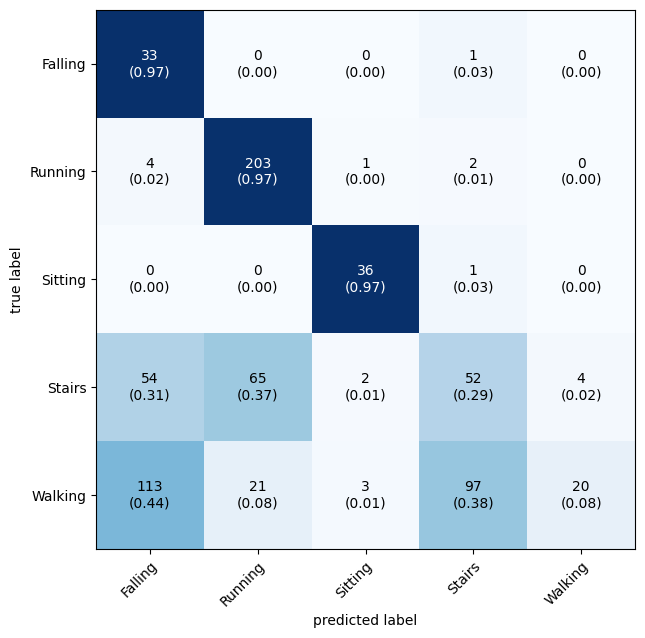

In [47]:
# load young chest trained model and test on elderly chest test
model_pretrained = load_model('models/new/lstm_6_young_body.h5')
y_pred = np.argmax(model_pretrained.predict(X_test), axis=-1)

mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)
